In [1]:
% matplotlib inline

from __future__ import division

import glob
import os
import numpy as np
from collections import namedtuple
from fractions import Fraction

import colour
from colour.plotting import *

from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_DDFAPD)
from colour_hdri.exif import get_exif_data
from colour_hdri.merge import merge_to_hdri
from colour_hdri.weighting_functions import (
    hat_function,
    normal_distribution_function,
    weighting_function_Debevec1997)


DIRECTORY = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Fontainebleau_002/Panorama/'

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

ExifData = namedtuple('ExifData', ('aperture', 'shutter_speed', 'iso'))

Image = namedtuple('Image', ('path', 'data', 'exif_data'))


def custom_weight_function(a):
    a = np.asarray(a)

    return np.where(a < 0.5,
                   weighting_function_Debevec1997(a),
                   1)


def process(dng_files, 
            output_directory,
            batch_size=9, 
            black_level=None, 
            white_level=None, 
            post_demosaicing=False,
            weight_function=custom_weight_function):

    for dng_files in colour.batch(dng_files, batch_size):
        images = []
        for dng_file in dng_files:
            print('Reading "{}"...'.format(dng_file))
            exif_data = get_exif_data(dng_file)
            aperture = float(exif_data['EXIF']['Aperture Value'][0])
            shutter_speed = float(Fraction(
                exif_data['EXIF']['Shutter Speed Value'][0]))
            iso = float(exif_data['EXIF']['ISO'][0])

            images.append(Image(dng_file,
                                colour.read_image(dng_file.replace('dng', 'tiff')),
                                ExifData(aperture, shutter_speed, iso)))

        if post_demosaicing:
            if black_level is None:
                black_level = 0

            if white_level is None:
                white_level = 0
                for image in images:
                    white_level = max(white_level, np.max(image.data))

            # TODO: Need a mutable data structure here.
            scaled_images = []
            for image in images:
                print('Scaling "{}"...'.format(image.path))
                data = image.data - black_level
                data *= 1 / white_level

                scaled_images.append(Image(image.path, data, image.exif_data))
            
            images = scaled_images

        path = os.path.join(
            output_directory,
            '{0}_{1}.{2}'.format(
                os.path.splitext(os.path.basename(images[0].path))[0],
                batch_size,
                'exr'))

        print('Merging "{0}"...'.format(path))
        image = merge_to_hdri(images, custom_weight_function)

        if post_demosaicing:
            print('Demosaicing "{0}"...'.format(path))
            image = demosaicing_CFA_Bayer_bilinear(image)
        
        print('Writting "{0}"...'.format(path))
        colour.write_image(image, path)
        


DNG_FILES = glob.glob('{0}/*.dng'.format(DIRECTORY))

process(DNG_FILES, DIRECTORY)

Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Fontainebleau_002/Panorama/DSC_2175.dng"...
Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Fontainebleau_002/Panorama/DSC_2176.dng"...
Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Fontainebleau_002/Panorama/DSC_2177.dng"...
Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Fontainebleau_002/Panorama/DSC_2178.dng"...
Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Fontainebleau_002/Panorama/DSC_2179.dng"...
Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Fontainebleau_002/Panorama/DSC_2180.dng"...
Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Fontainebleau_002/Panorama/DSC_2181.dng"...
Reading "/Users/kels

/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour_hdri/merge.py:30: RuntimeWarning: invalid value encountered in true_divide
  image_c /= weight_c


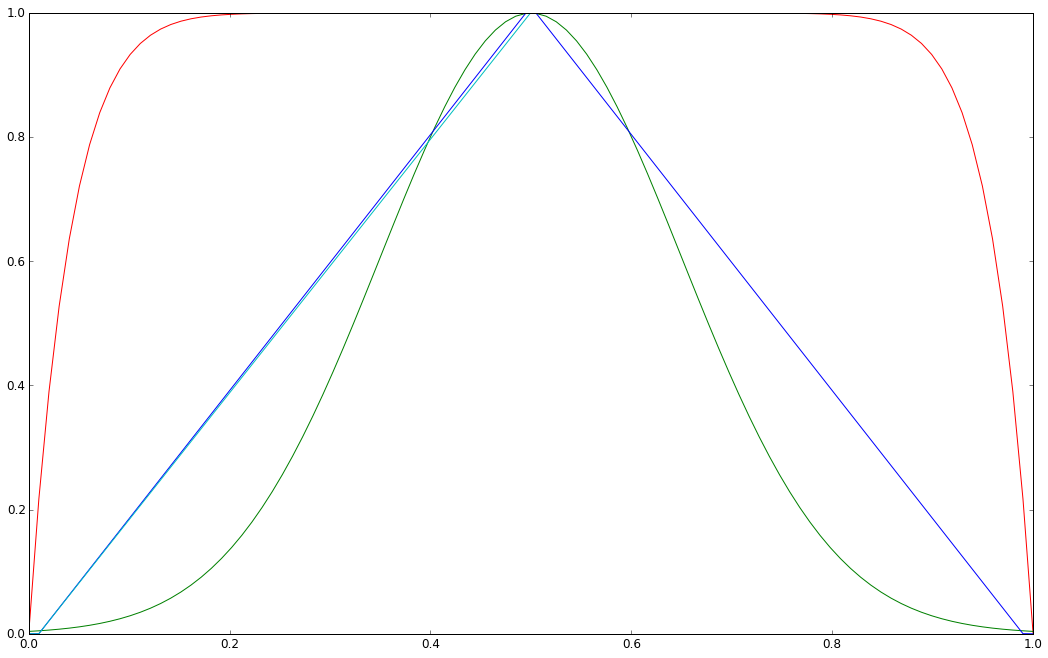

In [2]:
import pylab

pylab.plot(np.linspace(0, 1, 100), hat_function(np.linspace(0, 1, 100)), label='Hat')
pylab.plot(np.linspace(0, 1, 100), normal_distribution_function(np.linspace(0, 1, 100)), label='Normal')
pylab.plot(np.linspace(0, 1, 100), weighting_function_Debevec1997(np.linspace(0, 1, 100)), label='Debevec (1997)')
pylab.plot(np.linspace(0, 1, 1000), custom_weight_function(np.linspace(0, 1, 1000)), label='Custom')

pylab.show()